In [9]:
from tensorflow import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam, RMSprop

import numpy as np
import random
from collections import deque

import os
import sys
import time
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

### PNL Calculator

In [12]:
def PnLcalculator(actions, data):
    '''
    Arguments:
    actions: list of -1, 0, 1
    data: the data we perform actions on
    '''
    # act = {1:10,2:5,3:1,4:0,5:-1,6:-5,7:-10}
    # act = {1:5,2:1,3:0,4:-1,5:-5}
    time = 0
    position = 0
    unr_pnl = 0
    instant_pnl = 0
    pnl = []  ## This is what we return -- every episode's pnl (could be 0)
    history = []
    reward=0
    for i in range(1,len(actions) - 2):
        tomorrow_bid = data.iloc[time + 1, 1]
        tomorrow_ask = data.iloc[time + 1, 2]
        if position == 0:
            # either long or short will not have realized pnl
            if actions[i] == 1:
                unr_pnl = -tomorrow_ask
                position=1
            elif actions[i] == -1:
                unr_pnl = tomorrow_bid
                position=-1
            pnl.append(0)



        elif position == 1:
            # short will cause pnl, long will do nothing, flat will cause pnl
            if actions[i] == 0:
                unr_pnl += tomorrow_bid- data.iloc[time, 1]
                pnl.append(0)
            elif actions[i] == -1:
                position=0
                instant_pnl = tomorrow_bid + unr_pnl
                unr_pnl = 0
                reward+=instant_pnl
                pnl.append(instant_pnl)
            else:
                pnl.append(0)

        else:
            # long or flat will cause pnl, short will not
            if actions[i] == 0:
                unr_pnl -= tomorrow_ask-data.iloc[time, 2]
                pnl.append(0)
            elif actions[i] == 1:
                position=0
                instant_pnl = -tomorrow_ask + unr_pnl
                unr_pnl = 0
                reward+=instant_pnl
                pnl.append(instant_pnl)
            else:
                pnl.append(0)

        time += 1

    # final clearing
    if position == -1:
        reward += unr_pnl-data.iloc[time+1, 1]
        pnl.append(-data.iloc[time + 1, 1] + unr_pnl)
    elif position == 1:
        reward += float(data.iloc[time+1, 2]+unr_pnl)
        pnl.append(data.iloc[time + 1, 2] + unr_pnl)

    return reward, pnl
    # return pnl

### Set the Parameters

In [14]:
#How many days lookback (say 31 for now), and the balance of the number of shares?
state_size = 2
action_size = 3 # Buy 10, 5, 1, Hold, Sell 1, 5, 10

In [15]:
batch_size = 32 #for Gradient descent. why??
Nshort=5
Nlong=20

In [50]:
class DQNAgent:
    def __init__(self, state_size, action_size): ## Hyperparameters for out problem
        self.state_size = state_size
        self.action_size = action_size
        self.inventory = 0   #max restriction of 10
        self.memory = deque(maxlen = 1000)
        self.gamma = 0.9 #discount rate for future rewards 
        self.epsilon = 1 #exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9
        
        self.learning_rate = 0.001 #SGD learning rate (step size for SGD Optimizer)
        
        self.model = self._build_model()
    
    def set_default(self):
        self.inventory = 0
#         self.epsilon = 1
        self.memory = deque(maxlen = 1000)
    
    
    def _build_model(self):   ## The Neural Network we will be using to estimate the function
        model = Sequential()
        model.add(Dense(units = 4, input_dim=self.state_size, activation="relu"))
        #model.add(Dropout(0.2))
#         model.add(Dense(units = 8, activation="relu"))
        #model.add(Dropout(0.2))
        #model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation = "linear"))
        model.compile(loss = "mse", optimizer = Adam(lr = self.learning_rate))
        
        return model
    
    def remember(self, state, action, rewards, next_state,done): #store in memory
        self.memory.append((state, action, rewards, next_state,done))
        
    def act(self, state,test): #based on exploration rate, pick a random action, or choose the optimal action
        if test == True:
            act_num = self.model.predict(state)
            return act_num[0]

        if np.random.rand() <= self.epsilon:
            return random.randrange(action_size)
        
        act_num = self.model.predict(state)
        
        #print(act_num[0])
        return act_num[0] #the action determined to be the best choice
    
    
    def replay(self, batch_size):
        start_timei = time.time()
        minibatch = random.sample(self.memory, batch_size)
#         print(minibatch)
#         print([list(x[0][0]) for x in minibatch])
        
        state_array = np.reshape([list(x[0][0]) for x in minibatch],[batch_size,self.state_size])
        action_list = [x[1] for x in minibatch]
        reward_array = np.array([x[2] for x in minibatch])
        next_state_array = np.reshape([list(x[3][0]) for x in minibatch],[batch_size,self.state_size])
        
        target = reward_array + self.gamma*np.array([max(x) for x in self.model.predict(next_state_array)]) 
        
        current_target = self.model.predict(state_array)
        
        i = 0
        
        for x in action_list:
            current_target[i,x] = target[i]  #update current target with the optimal one q*
            i+=1
           
        self.model.fit(state_array, current_target, batch_size = batch_size,epochs=1, verbose=0)
        #print(time.time() - start_timei, "after fit")
        
    def load(self, name):
        self.model.load_weights(name)
        
    def save(self, name):
        self.model.save_weights(name)       

In [19]:

# agent = DQNAgent(state_size, action_size)
# agent.load(output_dir + "/weights_20000_20.hdf5")
def evaluate(agent, validation):
    if validation == True:
        global clob,Nshort,Nlong,output_dir
        
        num_train = int(len(clob)*0.6)
        test_data = clob[num_train+1:].reset_index(drop=True)  #Validation Set
        
    else:
        test_set ='data/'+output_dir+'.csv'
        test_data = pd.read_csv(test_set)

    test_data['MidPrice'] = (test_data['bidPrice'] + test_data['offerPrice'])/2

    test_data['MA5'] = test_data['MidPrice'].rolling(window=Nshort).mean()
    test_data['MA20'] = test_data['MidPrice'].rolling(window=Nlong).mean()
    tprice5 = test_data['MA5'] 
    tprice20 = test_data['MA20'] 
    bid = test_data['bidPrice']
    offer = test_data['offerPrice']
    
    n_episodes = len(test_data)
    state_size = 2

    store_action = [] #for calculating PnL {7:-10, 6:-5, 5:-1, 4:0, 3:1, 2:5, 1:10}
    store_action_list = []
    action_pos =  {0:-1, 1:0, 2:1}
    agent.inventory = 0
    start_time = time.time()
    pnl_calc = []
    for step in range(state_size+4, int(n_episodes)):
        state = [(tprice5[step]-98)/4,(tprice20[step]-98)/4]
            
        state = np.reshape(list(state), [1,state_size])

        action_list = agent.act(state, True)
        action = np.argmax(action_list)
        store_action.append([action-1])
        store_action_list.append(action_list)

        pnl_calc.append(action-1)
        pos_siz = action_pos[action]
#         if step%1000==0:
#             print(time.time() - start_time)
    actiondf = pnl_calc
#     print(actiondf)
    reward, pnl = PnLcalculator(actiondf,test_data)
    print(np.cumsum(pnl))
    return store_action, store_action_list,reward,pnl

In [23]:
# path = r'/content/drive/My Drive/Colab Notebooks/'
for m in [0.01,0.05,0.1,0.2]:
    for n in [0.01,0.05,0.1,0.2]:
        theta=m
        sigma=n
        output_dir="sample_data_t"+str(theta)+"s"+str(sigma)+"_train"
        print(output_dir)

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        clob = pd.read_csv('data/'+output_dir+'.csv')

        clob['MidPrice'] = (clob['bidPrice'] + clob['offerPrice'])/2

        clob['Change_MidPrice'] = clob['MidPrice'].diff()

        clob['MA5'] = clob['MidPrice'].rolling(window=Nshort).mean()   
        clob['MA20'] = clob['MidPrice'].rolling(window=Nlong).mean()

        price5 = list(clob['MA5'])
        price20 = list(clob['MA20'])

        agent = DQNAgent(state_size, action_size)

        n_episodes = len(clob)*0.6  #60% of Whole dataset (including for lookback period)

        step = 19

        tracking_reward = {}
        action_track = {}
        action_pos = {0:-1, 1:0, 2:1}
        agent = DQNAgent(state_size, action_size)
        batch_size = 32
        done = False
        a= {}
        al = {}
        p = {}
        h = {}
        r={}
        init_buffer = 19 #longer MA period
        for i in range(20):
            cash = 0
            asset = 0
            tracking_reward[i] = []
            action_track[i] = []
            agent.set_default()
            begin_time = time.time()
            start_time = time.time()
            for step in range(state_size+init_buffer, int(n_episodes)-1):

                state = [(price5[step]-98)/4,(price20[step]-98)/4]

                state = np.reshape(list(state), [1,state_size])

                action_list = agent.act(state,False)
                action = np.argmax(action_list)
                action_track[i].append(action_list)
                pos_siz = action_pos[action]

                reward = pos_siz*(price5[step+1] - price5[step])

                # if (agent.inventory + pos_siz <= 10) and (agent.inventory + pos_siz >= -10):
                #     agent.inventory += pos_siz
                #     reward = agent.inventory*(price20[step+1] - price20[step])
                # else:
                #     #print("not allowed")
                #     reward = -20

                #print("Reward:",reward, "Cash:",cash, "Asset:",asset, "Position:",pos_siz, "Inventory:",agent.inventory)
                tracking_reward[i].append(reward)

                next_state = [(price5[step+1]-98)/4,(price20[step+1]-98)/4]
                next_state = np.reshape(list(next_state), [1,state_size])

                if step == (int(n_episodes)-1):
                    done = True

                agent.remember(state, action, reward, next_state, done)
                #print(time.time() - start_time)
                if len(agent.memory) > batch_size:
                    agent.replay(batch_size)


               # print(time.time() - start_time,"replay")

                if step%5000==0:
                    print(" Iteration: {}/{}, score: {:.4f}, eps: {}, time: {:.2f}".format(step,int(n_episodes),sum(tracking_reward[i]),agent.epsilon,time.time() - start_time))
                    start_time = time.time()
                    agent.save(output_dir + "/weights_" + '{:04d}'.format(step) + "_" + str(i) + ".hdf5")

            if agent.epsilon > agent.epsilon_min:   #decrease the exploration rate for future runs
                    agent.epsilon *= agent.epsilon_decay  


            a[i],al[i],r[i],p[i] = evaluate(agent,True)
            print(" Iteration: {}/20, score: {:.4f}, eps: {}, time: {:.2f}".format(i+1,sum(tracking_reward[i]),agent.epsilon,time.time() - begin_time))
        #     plot_result(clob,agent)
        store_results = {1:a, 2:al,3:p,4:h,5:tracking_reward,6:action_track}

        with open(output_dir+'.pickle','wb') as f:
            pickle.dump(store_results,f)



sample_data_t0.01s0.01_train
 Iteration: 5000/21600, score: 0.0000, eps: 1, time: 18.13
 Iteration: 10000/21600, score: 0.0000, eps: 1, time: 19.13
 Iteration: 15000/21600, score: 0.0000, eps: 1, time: 17.49
 Iteration: 20000/21600, score: 0.0000, eps: 1, time: 17.04
[0. 0. 0. ... 0. 0. 0.]
 Iteration: 1/20, score: 0.0000, eps: 0.9, time: 85.88
 Iteration: 5000/21600, score: 0.0000, eps: 0.9, time: 19.25
 Iteration: 10000/21600, score: 0.0000, eps: 0.9, time: 20.53
 Iteration: 15000/21600, score: 0.0000, eps: 0.9, time: 20.59
 Iteration: 20000/21600, score: 0.0000, eps: 0.9, time: 14.59
[0. 0. 0. ... 0. 0. 0.]
 Iteration: 2/20, score: 0.0000, eps: 0.81, time: 91.11
 Iteration: 5000/21600, score: 0.0000, eps: 0.81, time: 20.75
 Iteration: 10000/21600, score: 0.0000, eps: 0.81, time: 20.58
 Iteration: 15000/21600, score: 0.0000, eps: 0.81, time: 12.66
 Iteration: 20000/21600, score: 0.0000, eps: 0.81, time: 19.86
[0. 0. 0. ... 0. 0. 0.]
 Iteration: 3/20, score: 0.0000, eps: 0.72900000000

 Iteration: 5000/21600, score: -0.5400, eps: 0.9, time: 20.42
 Iteration: 10000/21600, score: 0.6600, eps: 0.9, time: 20.34
 Iteration: 15000/21600, score: 1.2000, eps: 0.9, time: 20.28
 Iteration: 20000/21600, score: 0.8600, eps: 0.9, time: 18.40
[0.  0.  0.  ... 0.  0.  0.3]
 Iteration: 2/20, score: 1.0800, eps: 0.81, time: 89.16
 Iteration: 5000/21600, score: -0.0800, eps: 0.81, time: 12.26
 Iteration: 10000/21600, score: -0.5600, eps: 0.81, time: 21.33
 Iteration: 15000/21600, score: -1.2800, eps: 0.81, time: 20.14
 Iteration: 20000/21600, score: -1.8200, eps: 0.81, time: 20.63
[0.  0.  0.  ... 0.  0.  0.1]
 Iteration: 3/20, score: -1.5200, eps: 0.7290000000000001, time: 87.53
 Iteration: 5000/21600, score: -0.8800, eps: 0.7290000000000001, time: 21.34
 Iteration: 10000/21600, score: -0.7000, eps: 0.7290000000000001, time: 21.18
 Iteration: 15000/21600, score: -0.5600, eps: 0.7290000000000001, time: 16.63
 Iteration: 20000/21600, score: -3.0000, eps: 0.7290000000000001, time: 21.34

 Iteration: 10000/21600, score: 5.9800, eps: 0.9, time: 21.06
 Iteration: 15000/21600, score: 9.4600, eps: 0.9, time: 19.02
 Iteration: 20000/21600, score: 15.9000, eps: 0.9, time: 20.15
[  0.     0.     0.   ... 296.35 296.35 296.75]
 Iteration: 2/20, score: 19.0200, eps: 0.81, time: 95.11
 Iteration: 5000/21600, score: 8.3000, eps: 0.81, time: 19.03
 Iteration: 10000/21600, score: 18.4400, eps: 0.81, time: 21.61
 Iteration: 15000/21600, score: 26.8600, eps: 0.81, time: 17.18
 Iteration: 20000/21600, score: 39.5000, eps: 0.81, time: 20.00
[  0.     0.     0.   ... 290.05 290.05 290.4 ]
 Iteration: 3/20, score: 43.7000, eps: 0.7290000000000001, time: 92.30
 Iteration: 5000/21600, score: 11.7600, eps: 0.7290000000000001, time: 20.07
 Iteration: 10000/21600, score: 28.1200, eps: 0.7290000000000001, time: 22.05
 Iteration: 15000/21600, score: 41.3200, eps: 0.7290000000000001, time: 21.57
 Iteration: 20000/21600, score: 57.6400, eps: 0.7290000000000001, time: 21.65
[  0.     0.     0.   ..

 Iteration: 15000/21600, score: -0.5800, eps: 1, time: 21.48
 Iteration: 20000/21600, score: 0.4800, eps: 1, time: 21.61
[   0.     0.     0.  ...    0.     0.  -291.4]
 Iteration: 1/20, score: 1.9400, eps: 0.9, time: 106.99
 Iteration: 5000/21600, score: 4.0800, eps: 0.9, time: 21.37
 Iteration: 10000/21600, score: 11.9800, eps: 0.9, time: 22.07
 Iteration: 15000/21600, score: 15.8800, eps: 0.9, time: 21.74
 Iteration: 20000/21600, score: 22.7400, eps: 0.9, time: 21.94
[   0.     0.     0.  ...    0.     0.  -337.4]
 Iteration: 2/20, score: 27.3200, eps: 0.81, time: 108.30
 Iteration: 5000/21600, score: 9.3600, eps: 0.81, time: 14.31
 Iteration: 10000/21600, score: 22.8800, eps: 0.81, time: 22.49
 Iteration: 15000/21600, score: 29.3000, eps: 0.81, time: 22.49
 Iteration: 20000/21600, score: 40.1000, eps: 0.81, time: 22.29
[   0.      0.      0.   ...    0.      0.   -343.85]
 Iteration: 3/20, score: 46.6800, eps: 0.7290000000000001, time: 103.03
 Iteration: 5000/21600, score: 13.3000,

 Iteration: 20000/21600, score: 177.9600, eps: 0.13508517176729928, time: 25.00
[   0.     0.     0.  ...    0.     0.  -305.8]
 Iteration: 20/20, score: 197.8800, eps: 0.12157665459056936, time: 119.79
sample_data_t0.05s0.01_train
 Iteration: 5000/21600, score: 0.0000, eps: 1, time: 22.84
 Iteration: 10000/21600, score: 0.0000, eps: 1, time: 22.47
 Iteration: 15000/21600, score: 0.0000, eps: 1, time: 21.91
 Iteration: 20000/21600, score: 0.0000, eps: 1, time: 21.81
[ 0.   0.   0.  ... -0.1 -0.1 -0.1]
 Iteration: 1/20, score: 0.0000, eps: 0.9, time: 110.21
 Iteration: 5000/21600, score: 0.0000, eps: 0.9, time: 22.04
 Iteration: 10000/21600, score: 0.0000, eps: 0.9, time: 22.20
 Iteration: 15000/21600, score: 0.0000, eps: 0.9, time: 22.42
 Iteration: 20000/21600, score: 0.0000, eps: 0.9, time: 22.30
[ 0.   0.   0.  ... -0.1 -0.1 -0.1]
 Iteration: 2/20, score: 0.0000, eps: 0.81, time: 110.74
 Iteration: 5000/21600, score: 0.0000, eps: 0.81, time: 22.36
 Iteration: 10000/21600, score: 0.0

 Iteration: 5000/21600, score: 0.1000, eps: 1, time: 23.11
 Iteration: 10000/21600, score: 0.2400, eps: 1, time: 22.22
 Iteration: 15000/21600, score: -0.0400, eps: 1, time: 22.19
 Iteration: 20000/21600, score: 0.0800, eps: 1, time: 22.10
[  0.    0.    0.  ...   0.    0.  -28.9]
 Iteration: 1/20, score: 0.4000, eps: 0.9, time: 112.13
 Iteration: 5000/21600, score: 2.2600, eps: 0.9, time: 20.67
 Iteration: 10000/21600, score: 5.1000, eps: 0.9, time: 22.47
 Iteration: 15000/21600, score: 6.9400, eps: 0.9, time: 22.47
 Iteration: 20000/21600, score: 10.3200, eps: 0.9, time: 22.62
[ 0.    0.    0.   ... 68.55 68.55 68.65]
 Iteration: 2/20, score: 10.8000, eps: 0.81, time: 107.66
 Iteration: 5000/21600, score: 5.9800, eps: 0.81, time: 22.00
 Iteration: 10000/21600, score: 11.0000, eps: 0.81, time: 22.81
 Iteration: 15000/21600, score: 16.0800, eps: 0.81, time: 22.90
 Iteration: 20000/21600, score: 22.7200, eps: 0.81, time: 22.95
[ 0.    0.    0.   ... 96.85 96.85 96.95]
 Iteration: 3/20, 

[ 0.    0.    0.   ... 81.1  81.1  81.15]
 Iteration: 20/20, score: 106.9600, eps: 0.12157665459056936, time: 124.11
sample_data_t0.05s0.1_train
 Iteration: 5000/21600, score: 0.3600, eps: 1, time: 20.60
 Iteration: 10000/21600, score: 0.4000, eps: 1, time: 22.05
 Iteration: 15000/21600, score: -0.2000, eps: 1, time: 22.20
 Iteration: 20000/21600, score: -0.0200, eps: 1, time: 22.21
[  0.    0.    0.  ...   0.    0.  -14.2]
 Iteration: 1/20, score: 0.6200, eps: 0.9, time: 109.17
 Iteration: 5000/21600, score: 4.3800, eps: 0.9, time: 22.36
 Iteration: 10000/21600, score: 10.6000, eps: 0.9, time: 22.62
 Iteration: 15000/21600, score: 12.7400, eps: 0.9, time: 16.77
 Iteration: 20000/21600, score: 16.8800, eps: 0.9, time: 22.88
[  0.    0.    0.  ... 148.1 148.1 148.2]
 Iteration: 2/20, score: 18.9600, eps: 0.81, time: 107.40
 Iteration: 5000/21600, score: 12.6800, eps: 0.81, time: 15.11
 Iteration: 10000/21600, score: 21.0000, eps: 0.81, time: 23.65
 Iteration: 15000/21600, score: 29.4000

 Iteration: 15000/21600, score: 91.5800, eps: 0.13508517176729928, time: 20.13
 Iteration: 20000/21600, score: 119.4600, eps: 0.13508517176729928, time: 26.51
[ 0.   0.   0.  ... 96.9 96.9 96.8]
 Iteration: 20/20, score: 129.2800, eps: 0.12157665459056936, time: 121.95
sample_data_t0.05s0.2_train
 Iteration: 5000/21600, score: 0.4000, eps: 1, time: 22.80
 Iteration: 10000/21600, score: 1.0600, eps: 1, time: 22.90
 Iteration: 15000/21600, score: -0.2800, eps: 1, time: 22.72
 Iteration: 20000/21600, score: -0.0200, eps: 1, time: 22.73
[  0.     0.     0.   ... 469.05 469.05 471.15]
 Iteration: 1/20, score: 1.2000, eps: 0.9, time: 113.57
 Iteration: 5000/21600, score: 9.6000, eps: 0.9, time: 23.44
 Iteration: 10000/21600, score: 17.2200, eps: 0.9, time: 23.11
 Iteration: 15000/21600, score: 26.7600, eps: 0.9, time: 23.29
 Iteration: 20000/21600, score: 30.8200, eps: 0.9, time: 23.65
[  0.    0.    0.  ... 621.1 621.1 621.5]
 Iteration: 2/20, score: 35.9200, eps: 0.81, time: 112.01
 Iterat

[  0.     0.     0.   ... 514.25 514.25 514.05]
 Iteration: 19/20, score: 341.8000, eps: 0.13508517176729928, time: 130.55
 Iteration: 5000/21600, score: 85.9400, eps: 0.13508517176729928, time: 26.44
 Iteration: 10000/21600, score: 172.4000, eps: 0.13508517176729928, time: 26.58
 Iteration: 15000/21600, score: 245.7400, eps: 0.13508517176729928, time: 26.79
 Iteration: 20000/21600, score: 322.7200, eps: 0.13508517176729928, time: 18.86
[  0.    0.    0.  ... 478.2 478.2 477.8]
 Iteration: 20/20, score: 351.2000, eps: 0.12157665459056936, time: 122.98
sample_data_t0.1s0.01_train
 Iteration: 5000/21600, score: 0.0000, eps: 1, time: 22.19
 Iteration: 10000/21600, score: 0.0000, eps: 1, time: 23.28
 Iteration: 15000/21600, score: 0.0000, eps: 1, time: 23.13
 Iteration: 20000/21600, score: 0.0000, eps: 1, time: 23.16
[ 0.   0.   0.  ... -0.1 -0.1 -0.1]
 Iteration: 1/20, score: 0.0000, eps: 0.9, time: 114.63
 Iteration: 5000/21600, score: 0.0000, eps: 0.9, time: 23.01
 Iteration: 10000/2160

 Iteration: 15000/21600, score: 0.0000, eps: 0.13508517176729928, time: 27.07
 Iteration: 20000/21600, score: 0.0000, eps: 0.13508517176729928, time: 26.74
[0. 0. 0. ... 0. 0. 0.]
 Iteration: 20/20, score: 0.0000, eps: 0.12157665459056936, time: 124.06
sample_data_t0.1s0.05_train
 Iteration: 5000/21600, score: 0.2000, eps: 1, time: 24.13
 Iteration: 10000/21600, score: 0.1600, eps: 1, time: 23.85
 Iteration: 15000/21600, score: -0.0600, eps: 1, time: 23.61
 Iteration: 20000/21600, score: -0.0200, eps: 1, time: 23.62
[0.  0.  0.  ... 2.1 2.1 1.9]
 Iteration: 1/20, score: 0.3000, eps: 0.9, time: 118.29
 Iteration: 5000/21600, score: 2.9200, eps: 0.9, time: 23.56
 Iteration: 10000/21600, score: 4.6400, eps: 0.9, time: 24.05
 Iteration: 15000/21600, score: 5.9800, eps: 0.9, time: 24.08
 Iteration: 20000/21600, score: 7.9000, eps: 0.9, time: 23.93
[ 0.    0.    0.   ... 46.55 46.55 46.45]
 Iteration: 2/20, score: 8.5000, eps: 0.81, time: 119.18
 Iteration: 5000/21600, score: 5.9200, eps: 0.

 Iteration: 5000/21600, score: 17.5000, eps: 0.13508517176729928, time: 25.99
 Iteration: 10000/21600, score: 31.8200, eps: 0.13508517176729928, time: 27.63
 Iteration: 15000/21600, score: 45.6800, eps: 0.13508517176729928, time: 27.60
 Iteration: 20000/21600, score: 62.0600, eps: 0.13508517176729928, time: 27.64
[  0.     0.     0.   ... -66.25 -66.25 -66.55]
 Iteration: 20/20, score: 66.9800, eps: 0.12157665459056936, time: 134.12
sample_data_t0.1s0.1_train
 Iteration: 5000/21600, score: 0.1600, eps: 1, time: 22.65
 Iteration: 10000/21600, score: 0.1000, eps: 1, time: 23.60
 Iteration: 15000/21600, score: -0.3000, eps: 1, time: 24.11
 Iteration: 20000/21600, score: -0.0200, eps: 1, time: 23.75
[  0.     0.     0.   ...   0.     0.   -48.75]
 Iteration: 1/20, score: 0.3200, eps: 0.9, time: 117.49
 Iteration: 5000/21600, score: 3.5800, eps: 0.9, time: 24.00
 Iteration: 10000/21600, score: 7.7000, eps: 0.9, time: 24.11
 Iteration: 15000/21600, score: 11.2800, eps: 0.9, time: 24.41
 Iter

[  0.     0.     0.   ... -59.8  -59.8  -59.75]
 Iteration: 19/20, score: 133.6400, eps: 0.13508517176729928, time: 128.72
 Iteration: 5000/21600, score: 28.6200, eps: 0.13508517176729928, time: 27.55
 Iteration: 10000/21600, score: 59.9000, eps: 0.13508517176729928, time: 20.37
 Iteration: 15000/21600, score: 89.9000, eps: 0.13508517176729928, time: 28.20
 Iteration: 20000/21600, score: 115.2000, eps: 0.13508517176729928, time: 28.39
[  0.     0.     0.   ... -69.15 -69.15 -69.15]
 Iteration: 20/20, score: 125.9600, eps: 0.12157665459056936, time: 129.65
sample_data_t0.1s0.2_train
 Iteration: 5000/21600, score: 0.2800, eps: 1, time: 25.93
 Iteration: 10000/21600, score: 0.5000, eps: 1, time: 24.70
 Iteration: 15000/21600, score: -0.4400, eps: 1, time: 24.52
 Iteration: 20000/21600, score: 0.0200, eps: 1, time: 24.04
[ 0.   0.   0.  ... -0.6 -0.6 -0.2]
 Iteration: 1/20, score: 0.6400, eps: 0.9, time: 119.03
 Iteration: 5000/21600, score: 8.4200, eps: 0.9, time: 24.44
 Iteration: 10000/

 Iteration: 10000/21600, score: 125.9600, eps: 0.1500946352969992, time: 28.45
 Iteration: 15000/21600, score: 181.1000, eps: 0.1500946352969992, time: 28.93
 Iteration: 20000/21600, score: 232.0000, eps: 0.1500946352969992, time: 28.44
[  0.    0.    0.  ... 201.3 201.3 201.6]
 Iteration: 19/20, score: 251.2000, eps: 0.13508517176729928, time: 139.18
 Iteration: 5000/21600, score: 60.4600, eps: 0.13508517176729928, time: 28.08
 Iteration: 10000/21600, score: 128.6000, eps: 0.13508517176729928, time: 28.17
 Iteration: 15000/21600, score: 189.2400, eps: 0.13508517176729928, time: 28.66
 Iteration: 20000/21600, score: 236.1600, eps: 0.13508517176729928, time: 28.71
[  0.     0.     0.   ... 218.25 218.25 218.5 ]
 Iteration: 20/20, score: 252.9800, eps: 0.12157665459056936, time: 130.69
sample_data_t0.2s0.01_train
 Iteration: 5000/21600, score: 0.0000, eps: 1, time: 26.39
 Iteration: 10000/21600, score: 0.0000, eps: 1, time: 24.73
 Iteration: 15000/21600, score: 0.0000, eps: 1, time: 24.7

[0. 0. 0. ... 0. 0. 0.]
 Iteration: 19/20, score: 0.0000, eps: 0.13508517176729928, time: 137.61
 Iteration: 5000/21600, score: 0.0000, eps: 0.13508517176729928, time: 28.54
 Iteration: 10000/21600, score: 0.0000, eps: 0.13508517176729928, time: 28.78
 Iteration: 15000/21600, score: 0.0000, eps: 0.13508517176729928, time: 22.27
 Iteration: 20000/21600, score: 0.0000, eps: 0.13508517176729928, time: 28.39
[0. 0. 0. ... 0. 0. 0.]
 Iteration: 20/20, score: 0.0000, eps: 0.12157665459056936, time: 129.21
sample_data_t0.2s0.05_train
 Iteration: 5000/21600, score: 0.0200, eps: 1, time: 26.57
 Iteration: 10000/21600, score: -0.0200, eps: 1, time: 25.22
 Iteration: 15000/21600, score: -0.1400, eps: 1, time: 25.05
 Iteration: 20000/21600, score: -0.1000, eps: 1, time: 25.02
[ 0.   0.   0.  ...  0.   0.  -0.1]
 Iteration: 1/20, score: 0.0200, eps: 0.9, time: 118.83
 Iteration: 5000/21600, score: 0.4000, eps: 0.9, time: 25.30
 Iteration: 10000/21600, score: -0.1000, eps: 0.9, time: 25.70
 Iteratio

[ 0.   0.   0.  ...  0.   0.  -0.1]
 Iteration: 19/20, score: -5.0400, eps: 0.13508517176729928, time: 134.97
 Iteration: 5000/21600, score: -0.4800, eps: 0.13508517176729928, time: 27.36
 Iteration: 10000/21600, score: -0.3800, eps: 0.13508517176729928, time: 29.24
 Iteration: 15000/21600, score: -0.9800, eps: 0.13508517176729928, time: 29.17
 Iteration: 20000/21600, score: -1.1200, eps: 0.13508517176729928, time: 29.20
[ 0.   0.   0.  ...  0.   0.  -0.1]
 Iteration: 20/20, score: -1.3600, eps: 0.12157665459056936, time: 141.27
sample_data_t0.2s0.1_train
 Iteration: 5000/21600, score: 0.1600, eps: 1, time: 27.46
 Iteration: 10000/21600, score: 0.0400, eps: 1, time: 25.79
 Iteration: 15000/21600, score: -0.2000, eps: 1, time: 25.64
 Iteration: 20000/21600, score: 0.0800, eps: 1, time: 25.39
[  0.   0.   0. ... -32. -32. -32.]
 Iteration: 1/20, score: 0.2000, eps: 0.9, time: 129.93
 Iteration: 5000/21600, score: 3.4400, eps: 0.9, time: 25.69
 Iteration: 10000/21600, score: 6.0000, eps: 

 Iteration: 10000/21600, score: 54.6800, eps: 0.1500946352969992, time: 30.31
 Iteration: 15000/21600, score: 81.5200, eps: 0.1500946352969992, time: 30.61
 Iteration: 20000/21600, score: 108.3200, eps: 0.1500946352969992, time: 30.71
[  0.    0.    0.  ... -88.5 -88.5 -88.9]
 Iteration: 19/20, score: 118.8400, eps: 0.13508517176729928, time: 150.08
 Iteration: 5000/21600, score: 28.6800, eps: 0.13508517176729928, time: 30.19
 Iteration: 10000/21600, score: 57.2000, eps: 0.13508517176729928, time: 30.66
 Iteration: 15000/21600, score: 85.5600, eps: 0.13508517176729928, time: 30.76
 Iteration: 20000/21600, score: 110.8400, eps: 0.13508517176729928, time: 31.15
[  0.    0.    0.  ... -95.3 -95.3 -95.7]
 Iteration: 20/20, score: 120.4800, eps: 0.12157665459056936, time: 149.87
sample_data_t0.2s0.2_train
 Iteration: 5000/21600, score: 0.0000, eps: 1, time: 28.89
 Iteration: 10000/21600, score: -0.0200, eps: 1, time: 26.87
 Iteration: 15000/21600, score: -0.5400, eps: 1, time: 26.86
 Iterat

 Iteration: 20000/21600, score: 197.7800, eps: 0.16677181699666577, time: 31.12
[   0.     0.     0.  ... -142.3 -142.3 -142.7]
 Iteration: 18/20, score: 213.0000, eps: 0.1500946352969992, time: 153.19
 Iteration: 5000/21600, score: 52.1000, eps: 0.1500946352969992, time: 30.44
 Iteration: 10000/21600, score: 105.1800, eps: 0.1500946352969992, time: 31.00
 Iteration: 15000/21600, score: 153.2600, eps: 0.1500946352969992, time: 31.12
 Iteration: 20000/21600, score: 199.5600, eps: 0.1500946352969992, time: 31.67
[   0.     0.     0.  ... -165.7 -165.7 -166.1]
 Iteration: 19/20, score: 217.8400, eps: 0.13508517176729928, time: 152.04
 Iteration: 5000/21600, score: 53.3000, eps: 0.13508517176729928, time: 30.37
 Iteration: 10000/21600, score: 112.1600, eps: 0.13508517176729928, time: 32.93
 Iteration: 15000/21600, score: 163.5000, eps: 0.13508517176729928, time: 31.26
 Iteration: 20000/21600, score: 216.3000, eps: 0.13508517176729928, time: 31.16
[   0.     0.     0.  ... -287.3 -287.3 -28

## Interacting with the env

sample_data_t0.01s0.01_train
[0. 0. 0. ... 0. 0. 0.]


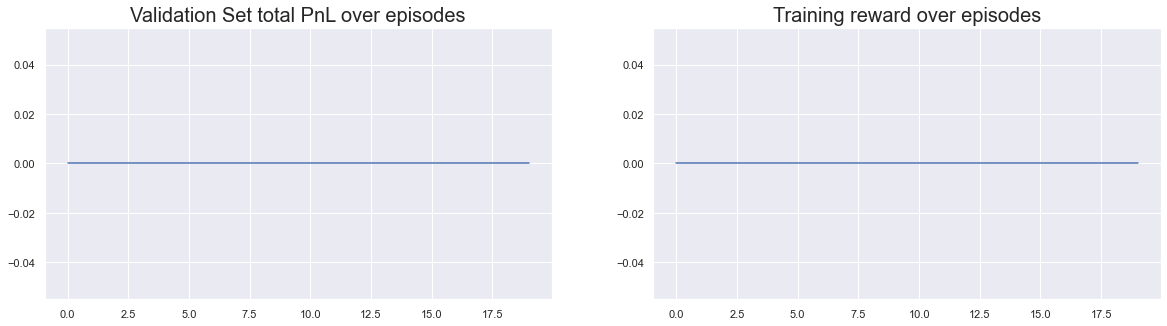

sample_data_t0.01s0.05_train
[0.  0.  0.  ... 0.  0.  0.1]


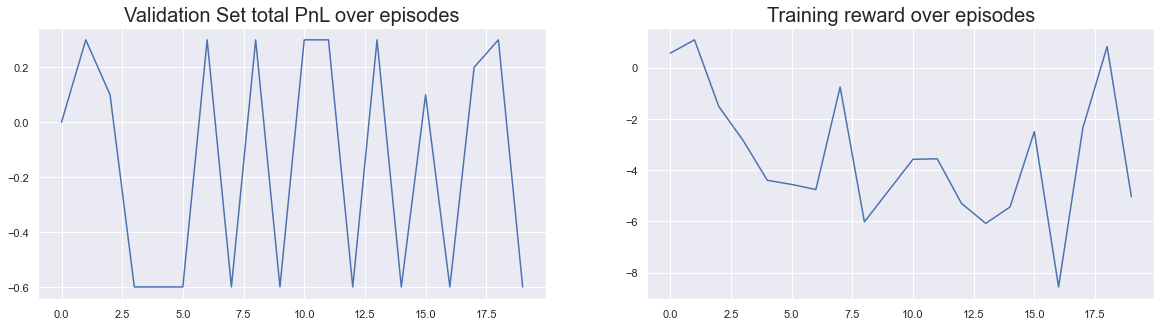

sample_data_t0.01s0.1_train
[  0.    0.    0.  ... 616.  616.  617.4]


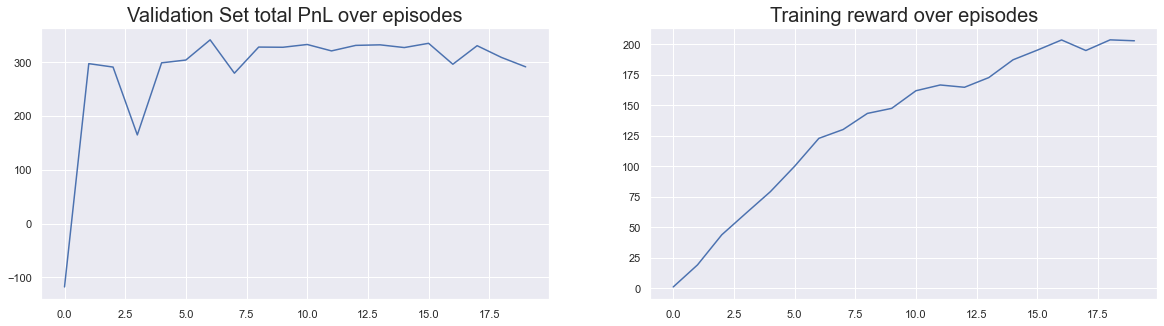

sample_data_t0.01s0.2_train
[   0.      0.      0.   ...    0.      0.   -726.25]


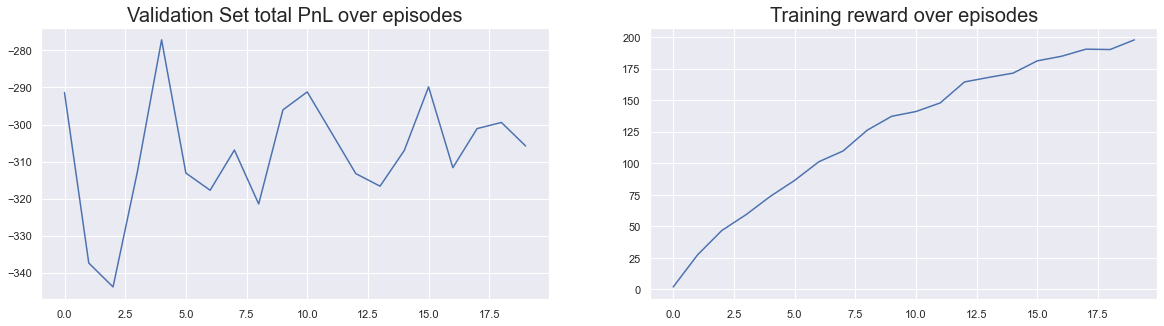

sample_data_t0.05s0.01_train
[0. 0. 0. ... 0. 0. 0.]


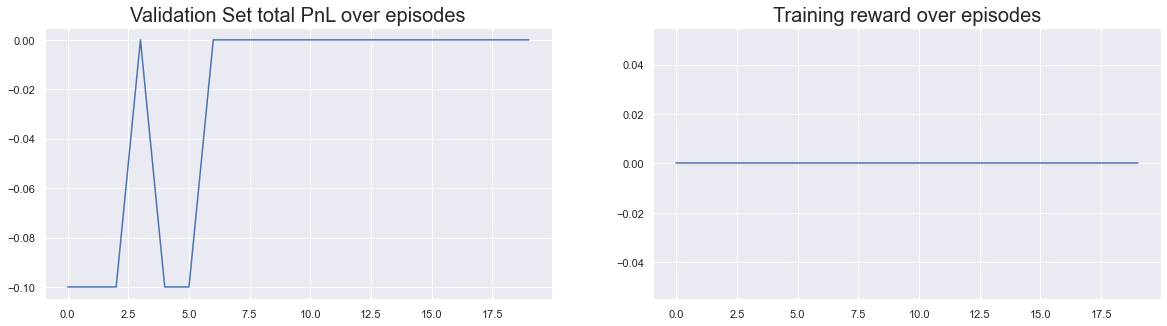

sample_data_t0.05s0.05_train
[  0.    0.    0.  ... 179.2 179.2 179.3]


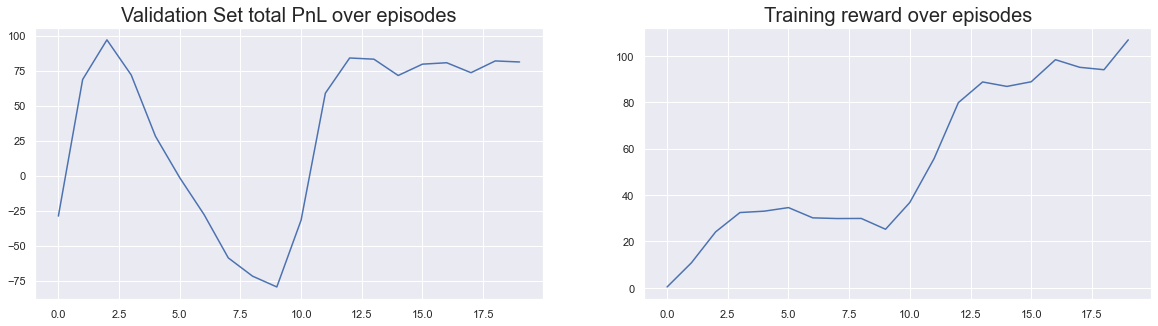

sample_data_t0.05s0.1_train
[  0.     0.     0.   ... 202.65 202.65 203.35]


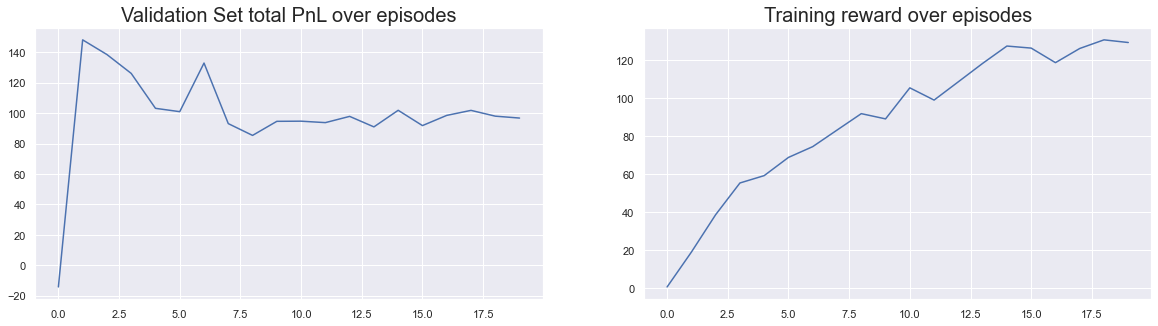

sample_data_t0.05s0.2_train
[   0.      0.      0.   ... 1453.95 1453.95 1453.35]


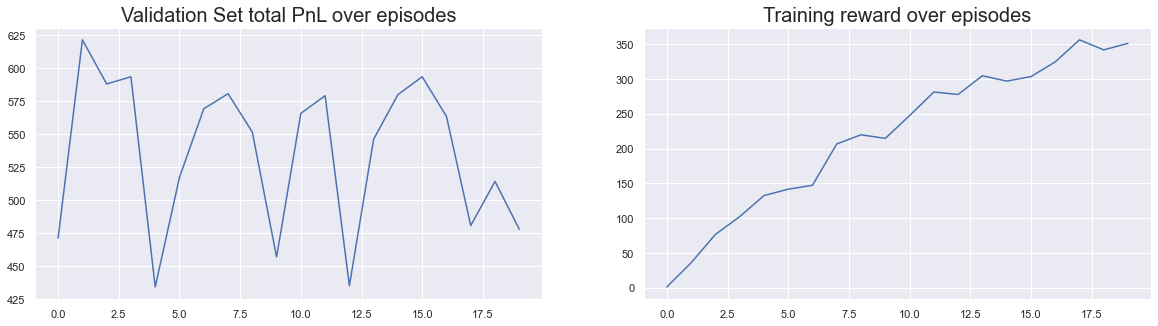

sample_data_t0.1s0.01_train
[0. 0. 0. ... 0. 0. 0.]


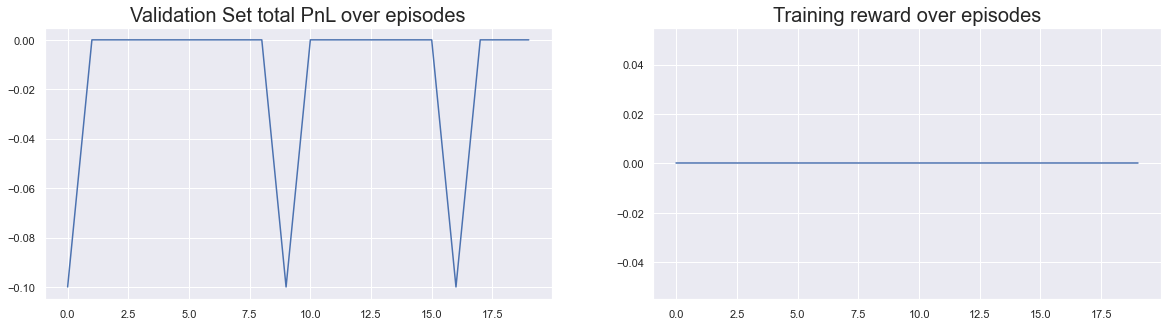

sample_data_t0.1s0.05_train
[ 0.   0.   0.  ... 87.8 87.8 87.9]


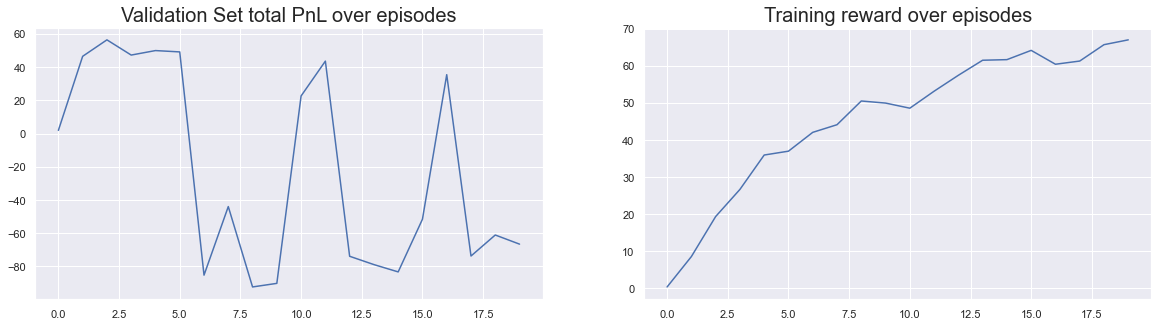

sample_data_t0.1s0.1_train
[  0.     0.     0.   ... 157.35 157.35 157.35]


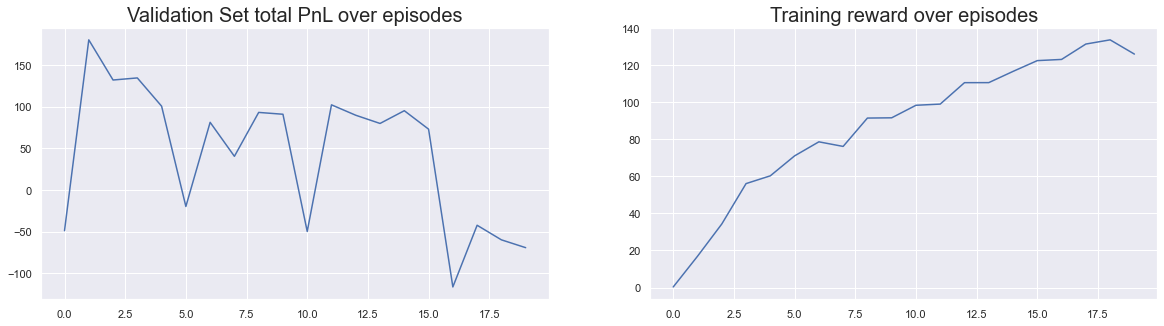

sample_data_t0.1s0.2_train
[  0.     0.     0.   ... 638.25 638.25 638.35]


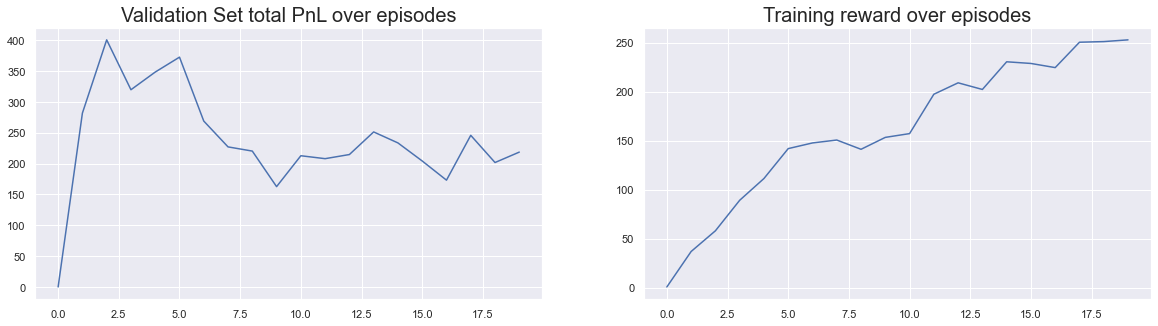

sample_data_t0.2s0.01_train
[0. 0. 0. ... 0. 0. 0.]


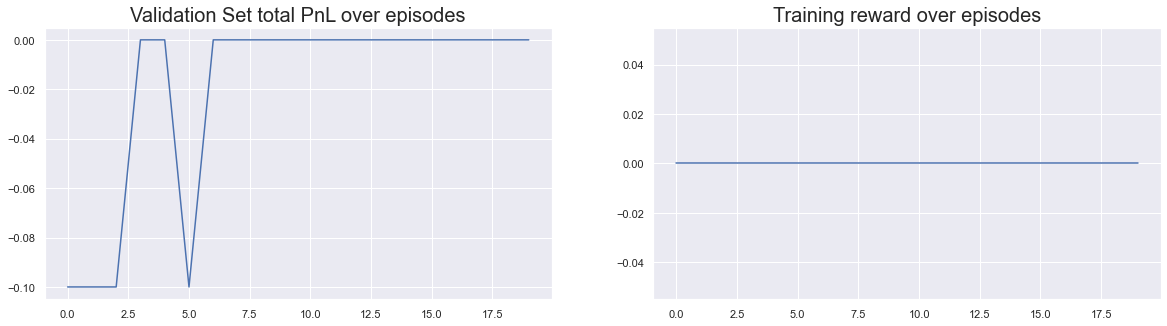

sample_data_t0.2s0.05_train
[0. 0. 0. ... 0. 0. 0.]


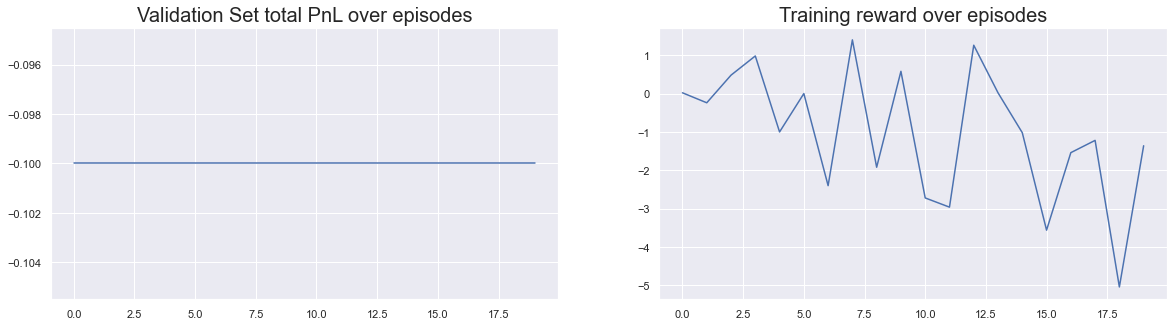

sample_data_t0.2s0.1_train
[   0.      0.      0.   ... -279.35 -279.35 -279.65]


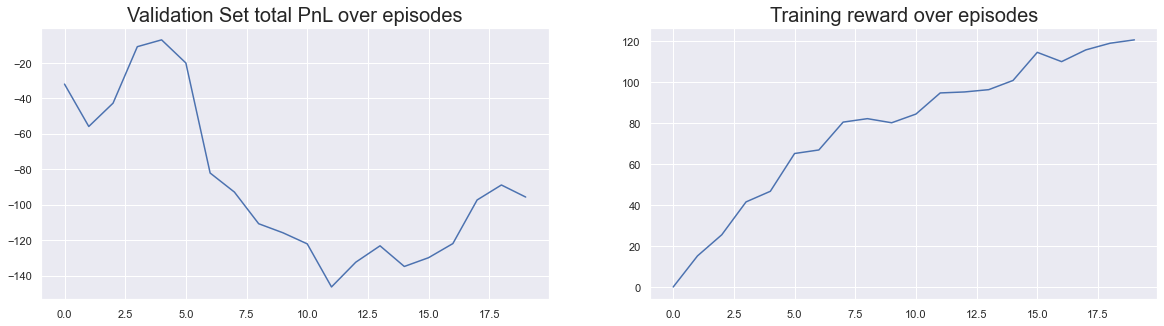

sample_data_t0.2s0.2_train
[ 0.   0.   0.  ... -3.9 -3.9 -4.6]


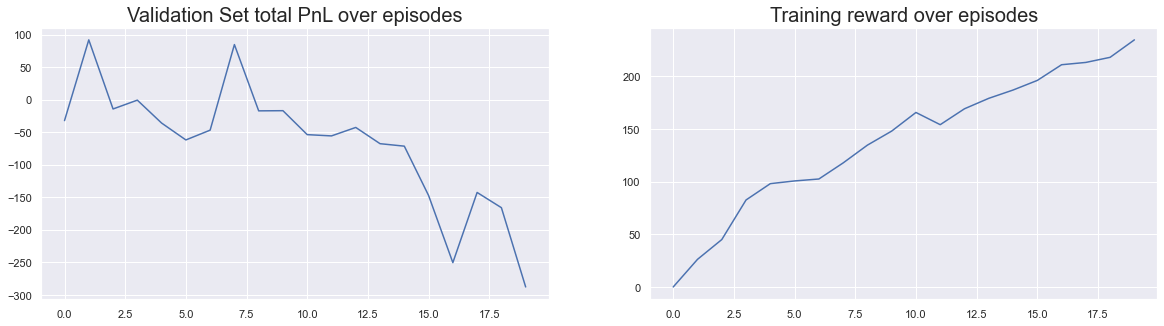

In [24]:
thetal=[]
sigmal=[]
pricel=[]
for m in [0.01,0.05,0.1,0.2]:
    for n in [0.01,0.05,0.1,0.2]:
        theta=m
        sigma=n
        output_dir="sample_data_t"+str(theta)+"s"+str(sigma)+"_train"
        print(output_dir)
        
        f1 = open(output_dir+'.pickle', 'rb')
        store_results=pickle.load(f1)
        f1.close()
        
        actions = store_results[1]    
        qvalue_actions = store_results[2]
        pnl = store_results[3]
        history = store_results[4]
        training = store_results[5]
        
        agent.load(output_dir + "/weights_20000_19.hdf5")
        
        a,al,p,h = evaluate(agent,False)
        thetal.append(theta)
        sigmal.append(sigma)
        pricel.append(h)
        
        plt.figure(figsize = (20,5))

        plt.subplot(121)
        plt.plot([sum(pnl[x]) for x in range(20)])
        plt.title( "Validation Set total PnL over episodes", fontdict = {'fontsize' : 20})

        plt.subplot(122)
        plt.plot([sum(training[x]) for x in range(20)])
        plt.title("Training reward over episodes", fontdict = {'fontsize' : 20})
        plt.show()


In [39]:
res=pd.DataFrame([thetal,sigmal,[sum(i) for i in pricel]]).transpose()
res.columns=["theta","sigma","testPnL"]
res.pivot(index="sigma",columns="theta",values="testPnL")


theta,0.01,0.05,0.10,0.20
sigma,,,,
0.01,0.00,0.00,0.00,0.00
0.05,0.10,179.30,87.90,0.00
0.10,617.40,203.35,157.35,-279.65
0.20,-726.25,1453.35,638.35,-4.60


sample_data_t0.2s0.1_train
[  0.     0.     0.   ... -19.95 -19.95 -20.15]


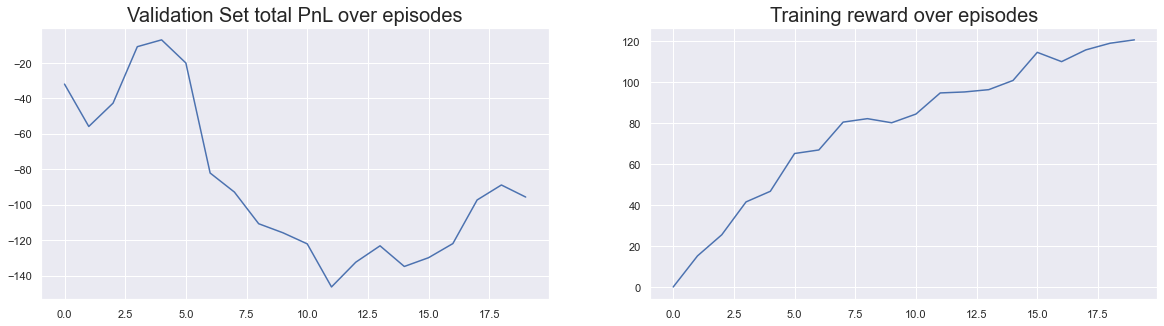

In [49]:
sigma=0.1
theta=0.2
output_dir="sample_data_t"+str(theta)+"s"+str(sigma)+"_train"
print(output_dir)

f1 = open(output_dir+'.pickle', 'rb')
store_results=pickle.load(f1)
f1.close()

actions = store_results[1]    
qvalue_actions = store_results[2]
pnl = store_results[3]
history = store_results[4]
training = store_results[5]

agent.load(output_dir + "/weights_20000_4.hdf5")

a,al,p,h = evaluate(agent,False)
thetal.append(theta)
sigmal.append(sigma)
pricel.append(h)

plt.figure(figsize = (20,5))

plt.subplot(121)
plt.plot([sum(pnl[x]) for x in range(20)])
plt.title( "Validation Set total PnL over episodes", fontdict = {'fontsize' : 20})

plt.subplot(122)
plt.plot([sum(training[x]) for x in range(20)])
plt.title("Training reward over episodes", fontdict = {'fontsize' : 20})
plt.show()

sample_data_t0.01s0.2_train
[   0.     0.     0.  ... 1503.6 1503.6 1506.2]


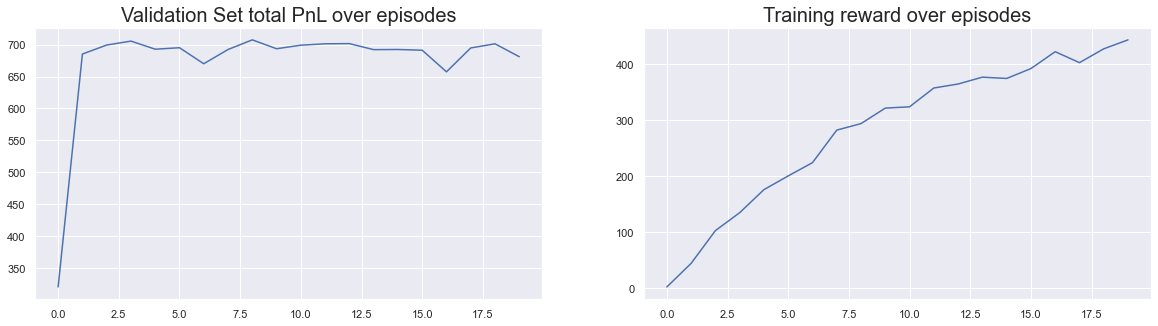

In [52]:
sigma=0.2
theta=0.01
output_dir="sample_data_t"+str(theta)+"s"+str(sigma)+"_train"
print(output_dir)

f1 = open(output_dir+'.pickle', 'rb')
store_results=pickle.load(f1)
f1.close()

actions = store_results[1]    
qvalue_actions = store_results[2]
pnl = store_results[3]
history = store_results[4]
training = store_results[5]

agent.load(output_dir + "/weights_20000_4.hdf5")

a,al,p,h = evaluate(agent,False)
thetal.append(theta)
sigmal.append(sigma)
pricel.append(h)

plt.figure(figsize = (20,5))

plt.subplot(121)
plt.plot([sum(pnl[x]) for x in range(20)])
plt.title( "Validation Set total PnL over episodes", fontdict = {'fontsize' : 20})

plt.subplot(122)
plt.plot([sum(training[x]) for x in range(20)])
plt.title("Training reward over episodes", fontdict = {'fontsize' : 20})
plt.show()

sample_data_t0.2s0.2_train
[  0.     0.     0.   ... 190.95 190.95 191.35]


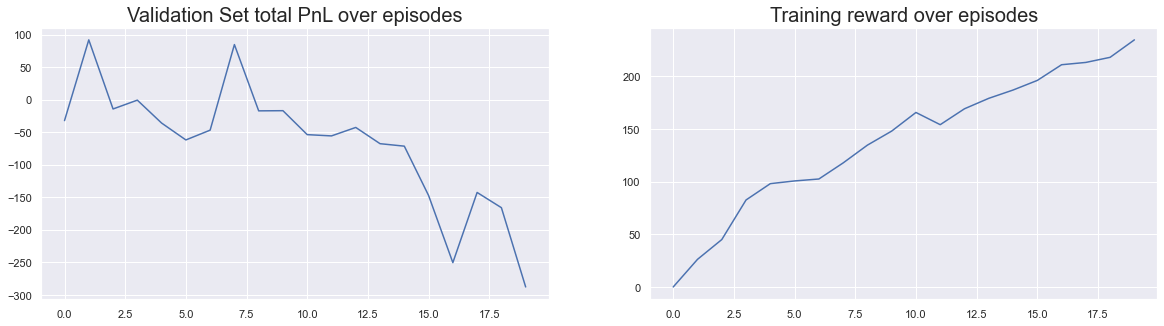

In [43]:
sigma=0.2
theta=0.2
output_dir="sample_data_t"+str(theta)+"s"+str(sigma)+"_train"
print(output_dir)

f1 = open(output_dir+'.pickle', 'rb')
store_results=pickle.load(f1)
f1.close()

actions = store_results[1]    
qvalue_actions = store_results[2]
pnl = store_results[3]
history = store_results[4]
training = store_results[5]

agent.load(output_dir + "/weights_20000_1.hdf5")

a,al,p,h = evaluate(agent,False)
thetal.append(theta)
sigmal.append(sigma)
pricel.append(h)

plt.figure(figsize = (20,5))

plt.subplot(121)
plt.plot([sum(pnl[x]) for x in range(20)])
plt.title( "Validation Set total PnL over episodes", fontdict = {'fontsize' : 20})

plt.subplot(122)
plt.plot([sum(training[x]) for x in range(20)])
plt.title("Training reward over episodes", fontdict = {'fontsize' : 20})
plt.show()

In [51]:
# path = r'/content/drive/My Drive/Colab Notebooks/'
sigma=0.2
theta=0.01
output_dir="sample_data_t"+str(theta)+"s"+str(sigma)+"_train"
print(output_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

clob = pd.read_csv('data/'+output_dir+'.csv')

clob['MidPrice'] = (clob['bidPrice'] + clob['offerPrice'])/2

clob['Change_MidPrice'] = clob['MidPrice'].diff()

clob['MA5'] = clob['MidPrice'].rolling(window=Nshort).mean()   
clob['MA20'] = clob['MidPrice'].rolling(window=Nlong).mean()

price5 = list(clob['MA5'])
price20 = list(clob['MA20'])

agent = DQNAgent(state_size, action_size)

n_episodes = len(clob)*0.6  #60% of Whole dataset (including for lookback period)

step = 19

tracking_reward = {}
action_track = {}
action_pos = {0:-1, 1:0, 2:1}
agent = DQNAgent(state_size, action_size)
batch_size = 32
done = False
a= {}
al = {}
p = {}
h = {}
r={}
init_buffer = 19 #longer MA period
for i in range(20):
    cash = 0
    asset = 0
    tracking_reward[i] = []
    action_track[i] = []
    agent.set_default()
    begin_time = time.time()
    start_time = time.time()
    for step in range(state_size+init_buffer, int(n_episodes)-1):

        state = [(price5[step]-98)/4,(price20[step]-98)/4]

        state = np.reshape(list(state), [1,state_size])

        action_list = agent.act(state,False)
        action = np.argmax(action_list)
        action_track[i].append(action_list)
        pos_siz = action_pos[action]

        reward = pos_siz*(price5[step+1] - price5[step])

        # if (agent.inventory + pos_siz <= 10) and (agent.inventory + pos_siz >= -10):
        #     agent.inventory += pos_siz
        #     reward = agent.inventory*(price20[step+1] - price20[step])
        # else:
        #     #print("not allowed")
        #     reward = -20

        #print("Reward:",reward, "Cash:",cash, "Asset:",asset, "Position:",pos_siz, "Inventory:",agent.inventory)
        tracking_reward[i].append(reward)

        next_state = [(price5[step+1]-98)/4,(price20[step+1]-98)/4]
        next_state = np.reshape(list(next_state), [1,state_size])

        if step == (int(n_episodes)-1):
            done = True

        agent.remember(state, action, reward, next_state, done)
        #print(time.time() - start_time)
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)


       # print(time.time() - start_time,"replay")

        if step%5000==0:
            print(" Iteration: {}/{}, score: {:.4f}, eps: {}, time: {:.2f}".format(step,int(n_episodes),sum(tracking_reward[i]),agent.epsilon,time.time() - start_time))
            start_time = time.time()
            agent.save(output_dir + "/weights_" + '{:04d}'.format(step) + "_" + str(i) + ".hdf5")

    if agent.epsilon > agent.epsilon_min:   #decrease the exploration rate for future runs
            agent.epsilon *= agent.epsilon_decay  


    a[i],al[i],r[i],p[i] = evaluate(agent,True)
    print(" Iteration: {}/20, score: {:.4f}, eps: {}, time: {:.2f}".format(i+1,sum(tracking_reward[i]),agent.epsilon,time.time() - begin_time))
#     plot_result(clob,agent)
store_results = {1:a, 2:al,3:p,4:h,5:tracking_reward,6:action_track}

with open(output_dir+'.pickle','wb') as f:
    pickle.dump(store_results,f)



sample_data_t0.01s0.2_train
 Iteration: 5000/21600, score: -0.6200, eps: 1, time: 28.66
 Iteration: 10000/21600, score: 0.7600, eps: 1, time: 23.20
 Iteration: 15000/21600, score: -0.5800, eps: 1, time: 26.33
 Iteration: 20000/21600, score: 0.4800, eps: 1, time: 23.78
[  0.     0.     0.   ... 317.75 317.75 320.1 ]
 Iteration: 1/20, score: 1.9400, eps: 0.9, time: 124.75
 Iteration: 5000/21600, score: 10.4200, eps: 0.9, time: 16.65
 Iteration: 10000/21600, score: 20.8800, eps: 0.9, time: 24.29
 Iteration: 15000/21600, score: 29.3800, eps: 0.9, time: 20.85
 Iteration: 20000/21600, score: 39.9600, eps: 0.9, time: 16.07
[  0.     0.     0.   ... 684.85 684.85 685.25]
 Iteration: 2/20, score: 44.1400, eps: 0.81, time: 102.54
 Iteration: 5000/21600, score: 24.6600, eps: 0.81, time: 12.36
 Iteration: 10000/21600, score: 48.7600, eps: 0.81, time: 22.93
 Iteration: 15000/21600, score: 69.6200, eps: 0.81, time: 25.39
 Iteration: 20000/21600, score: 91.4800, eps: 0.81, time: 13.55
[  0.     0.   

 Iteration: 15000/21600, score: 296.7800, eps: 0.13508517176729928, time: 27.58
 Iteration: 20000/21600, score: 400.1600, eps: 0.13508517176729928, time: 14.78
[  0.     0.     0.   ... 680.35 680.35 681.05]
 Iteration: 20/20, score: 443.8600, eps: 0.12157665459056936, time: 119.53
